<a href="https://colab.research.google.com/github/JaidenD/2P40_Heat/blob/master/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = "/content/drive/MyDrive/data"

Read in data and consolidate into one HDF5 file and check for formatting mistakes

In [8]:
# Define the directory containing the glider CSV files
data_dir = os.path.expanduser(data_path)
output_file = os.path.join(data_dir, "glider_data.csv")

# If the combined CSV file exists, delete it.
if os.path.exists(output_file):
    os.remove(output_file)
    print("Existing combined CSV removed:", output_file)

# Combine CSV files into one.
csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
header_written = False

with open(output_file, 'w', newline='') as fout:
    for csv_file in csv_files:
        # Skip the output file (just in case)
        if os.path.abspath(csv_file) == os.path.abspath(output_file):
            continue
        with open(csv_file, 'r') as fin:
            header = fin.readline()
            if not header_written:
                fout.write(header)
                header_written = True
            for line in fin:
                fout.write(line)
print("CSV files combined successfully into:", output_file)

# Define paths for CSV and HDF5 files.
csv_file = output_file
hdf_file = os.path.join(data_dir, "glider_data.h5")

# If the HDF5 file exists, delete it.
if os.path.exists(hdf_file):
    os.remove(hdf_file)
    print("Existing HDF5 file removed:", hdf_file)

# Define data types to reduce memory usage.
dtypes = {
    "longitude": "float32",
    "latitude": "float32",
    "depth": "float32",
    "time": "str",         # Keep as string if date parsing is not required immediately
    "salinity": "float32",
    "density": "float32",
    "temperature": "float32"
}

chunksize = 10**6  # Adjust based on your available memory

# Optionally, define a function to regularize each chunk's format.
def regularize_chunk(chunk):
    # Mapping original column names to standard ones (if necessary).
    col_mapping = {
        "sea_water_temperature": "temperature",
        "sea_water_practical_salinity": "salinity",
        "sea_water_density": "density",
        "micromoles_of_oxygen_per_unit_mass_in_sea_water": "oxygen"
    }
    chunk.rename(columns=col_mapping, inplace=True)

    # Enforce consistent data types (numeric columns to float32)
    for col in ["latitude", "longitude", "depth", "temperature", "salinity", "density", "oxygen"]:
        if col in chunk.columns:
            chunk[col] = pd.to_numeric(chunk[col], errors='coerce').astype("float32")

    # PRUNE NEGATIVE OXYGEN ROWS:
    # Remove any rows where oxygen is negative
    if "oxygen" in chunk.columns:
        chunk = chunk[chunk["oxygen"] > 0]

    return chunk

# Convert the combined CSV file into an HDF5 file using chunking.
with pd.HDFStore(hdf_file, mode='w') as store:
    for i, chunk in enumerate(pd.read_csv(csv_file, dtype=dtypes, chunksize=chunksize, low_memory=False)):
        # Regularize the chunk to ensure a consistent format.
        chunk = regularize_chunk(chunk)
        store.append('data', chunk, format='table', data_columns=True)
        print(f"Processed chunk {i}")
print("Conversion to HDF5 complete.")

# Read the HDF5 file and display the first few rows of data.
df = pd.read_hdf(hdf_file, 'data')
print("Head of combined data:")
print(df.head())

Existing combined CSV removed: /content/drive/MyDrive/data/glider_data.csv
CSV files combined successfully into: /content/drive/MyDrive/data/glider_data.csv
Existing HDF5 file removed: /content/drive/MyDrive/data/glider_data.h5
Processed chunk 0
Processed chunk 1
Processed chunk 2
Processed chunk 3
Processed chunk 4
Processed chunk 5
Processed chunk 6
Processed chunk 7
Processed chunk 8
Processed chunk 9
Processed chunk 10
Processed chunk 11
Processed chunk 12
Conversion to HDF5 complete.
Head of combined data:
                  time   latitude  longitude      depth  temperature  \
0  2020-07-17 18:52:10  47.417049 -63.907475  23.203598       3.0303   
1  2020-07-17 18:52:12  47.417049 -63.907467  23.332499       2.9849   
2  2020-07-17 18:52:14  47.417049 -63.907463  23.659710       2.9294   
3  2020-07-17 18:52:16  47.417049 -63.907459  23.838190       2.8807   
4  2020-07-17 18:52:18  47.417049 -63.907455  24.105907       2.8215   

    salinity      density      oxygen  
0  30.1954

## Explore data

Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 12018951 entries, 0 to 12019023
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   time         datetime64[ns]
 1   latitude     float32       
 2   longitude    float32       
 3   depth        float32       
 4   temperature  float32       
 5   salinity     float32       
 6   density      float32       
 7   oxygen       float32       
dtypes: datetime64[ns](1), float32(7)
memory usage: 504.3 MB
None

Data Description:
                                time      latitude     longitude  \
count                       12018951  1.201895e+07  1.201895e+07   
mean   2021-12-27 10:09:59.968700160  4.808322e+01 -6.252581e+01   
min              2018-07-20 01:02:01  4.702936e+01 -6.443135e+01   
25%       2021-07-14 20:11:39.500000  4.758998e+01 -6.370713e+01   
50%              2022-05-13 20:05:26  4.792887e+01 -6.281747e+01   
75%              2023-05-03 20:07:19  4.858593e+01

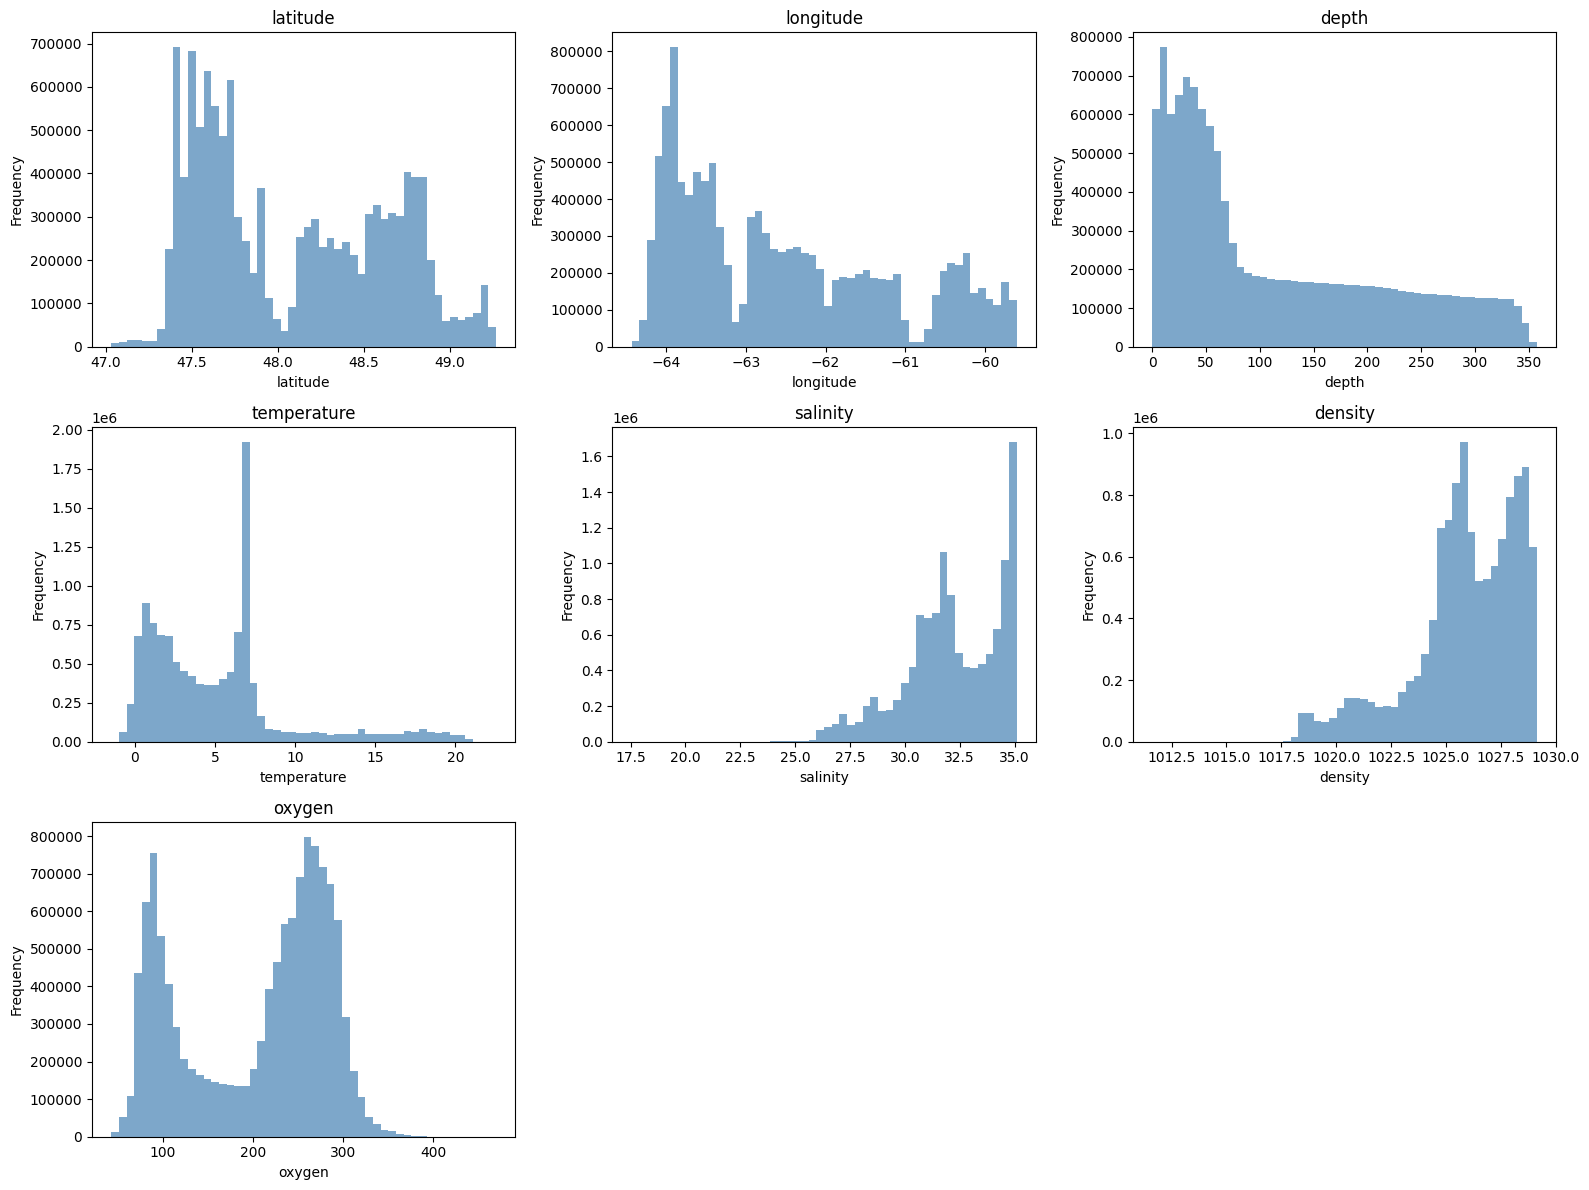

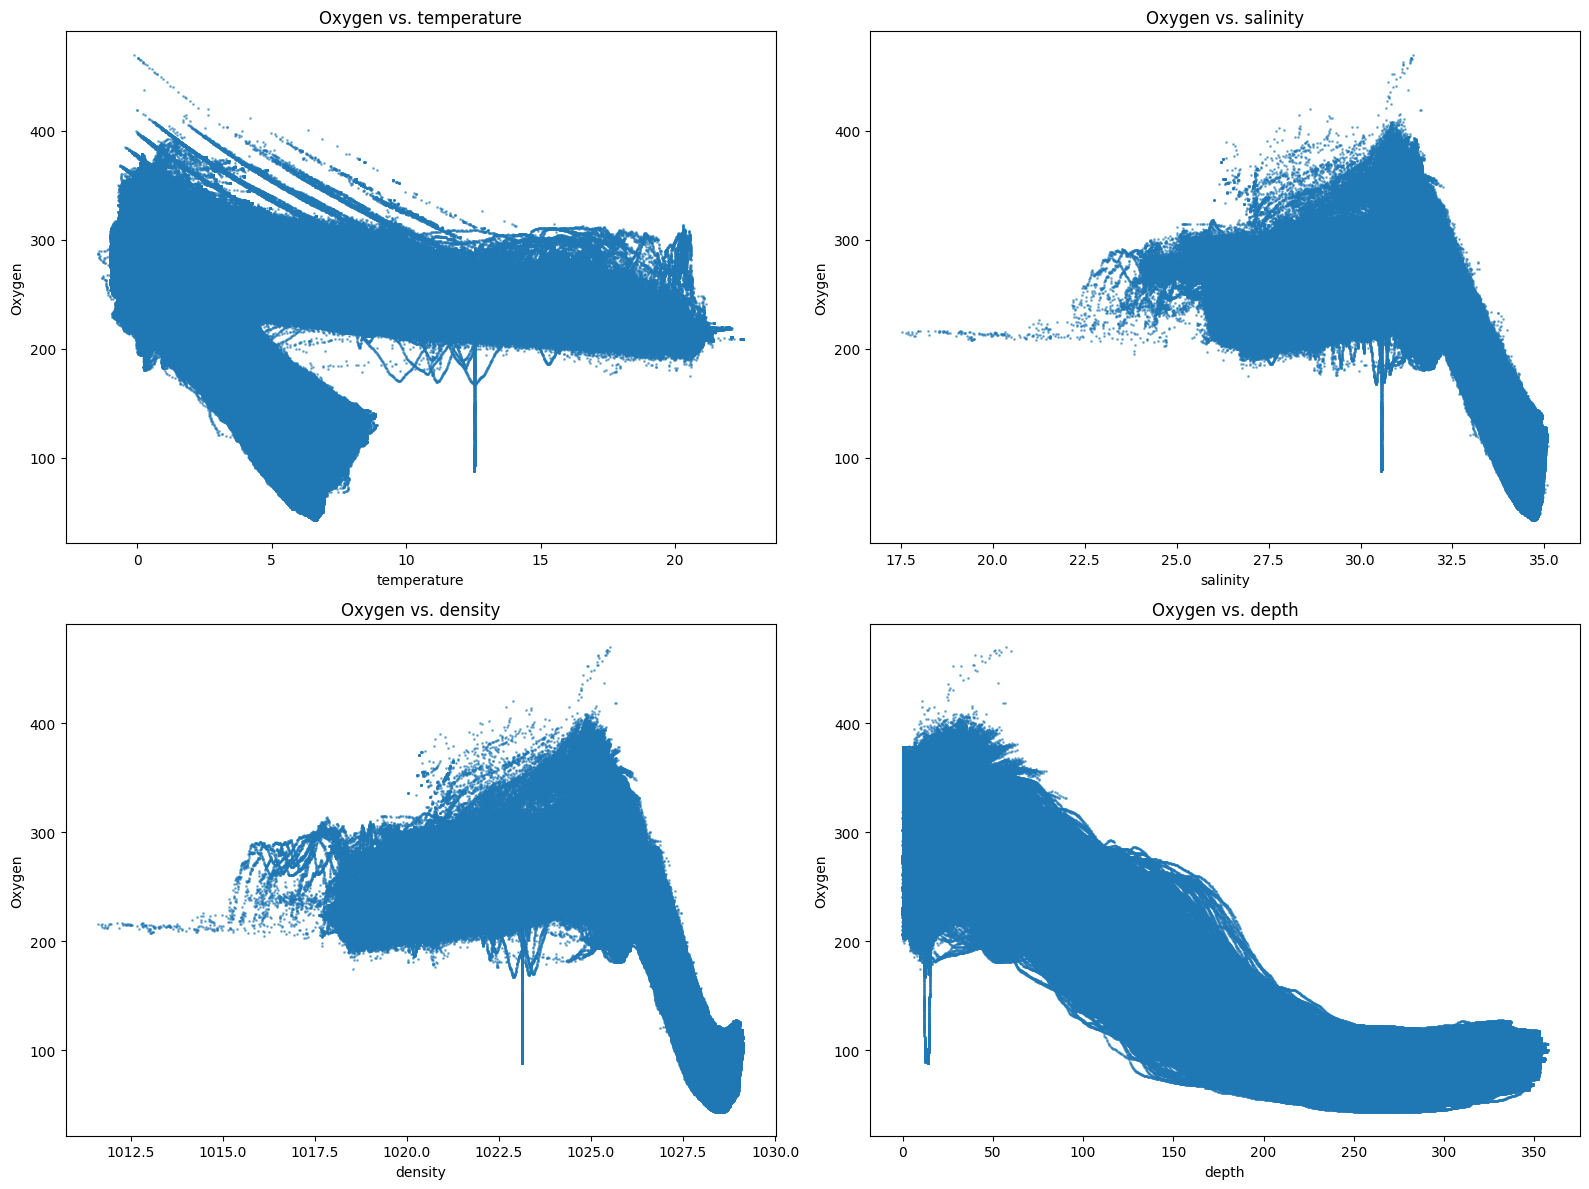

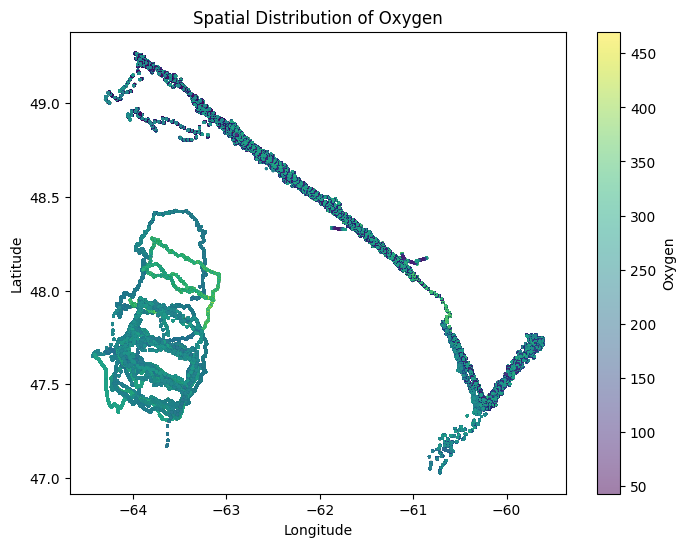

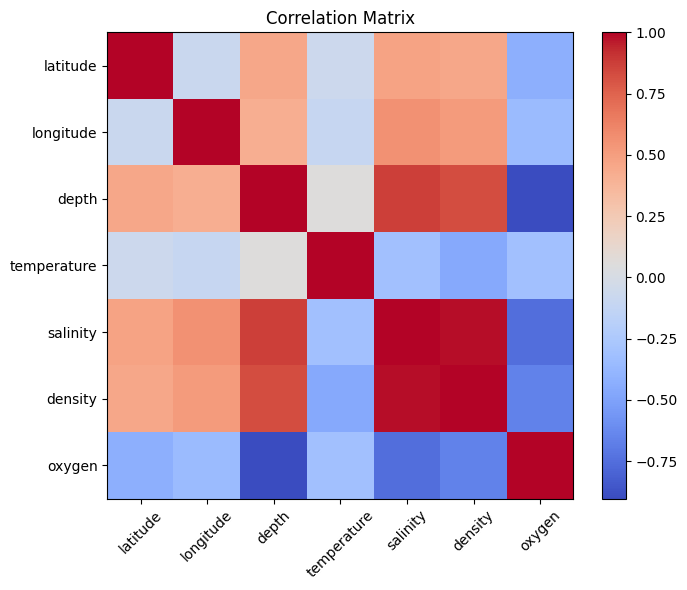

In [6]:
# Define the data directory and HDF5 file path.
data_dir = os.path.expanduser(data_path)
hdf_file = os.path.join(data_dir, "glider_data.h5")

# Load the data from HDF5.
df = pd.read_hdf(hdf_file, 'data')

# Optionally, convert the time column to datetime (if not already done).
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Print basic info and summary statistics.
print("Data Information:")
print(df.info())
print("\nData Description:")
print(df.describe())

# -----------------------------
# Plot histograms for all numeric variables.
# -----------------------------
numeric_columns = ['latitude', 'longitude', 'depth', 'temperature', 'salinity', 'density', 'oxygen']

plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_columns):
    plt.subplot(3, 3, i + 1)
    plt.hist(df[col].dropna(), bins=50, alpha=0.7, color='steelblue')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# -----------------------------
# Scatter plots of oxygen vs. key predictors.
# -----------------------------
predictors = ['temperature', 'salinity', 'density', 'depth']
plt.figure(figsize=(16, 12))
for i, col in enumerate(predictors):
    plt.subplot(2, 2, i + 1)
    plt.scatter(df[col], df['oxygen'], alpha=0.5, s=1)
    plt.xlabel(col)
    plt.ylabel('Oxygen')
    plt.title(f'Oxygen vs. {col}')
plt.tight_layout()
plt.show()

# -----------------------------
# Spatial plot: Latitude vs. Longitude colored by oxygen.
# -----------------------------
plt.figure(figsize=(8, 6))
sc = plt.scatter(df['longitude'], df['latitude'], c=df['oxygen'], cmap='viridis', alpha=0.5, s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Oxygen')
plt.colorbar(sc, label='Oxygen')
plt.show()

# -----------------------------
# Correlation Matrix Heatmap.
# -----------------------------
corr = df[numeric_columns].corr()
plt.figure(figsize=(8, 6))
im = plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.title("Correlation Matrix")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

density and salinity highly correlated. Think of dead sea

In [ ]:
# Define the data directory and HDF5 file path
data_dir = os.path.expanduser(data_path)
hdf_file = os.path.join(data_dir, "glider_data.h5")

# Load the data from HDF5
df = pd.read_hdf(hdf_file, 'data')

# Calculate and print the correlation
corr_value = df["density"].corr(df["salinity"])
print("Correlation between density and salinity:", corr_value)

Correlation between density and salinity: 0.9834366631995999


# Lets try DFT

it is essentially useless

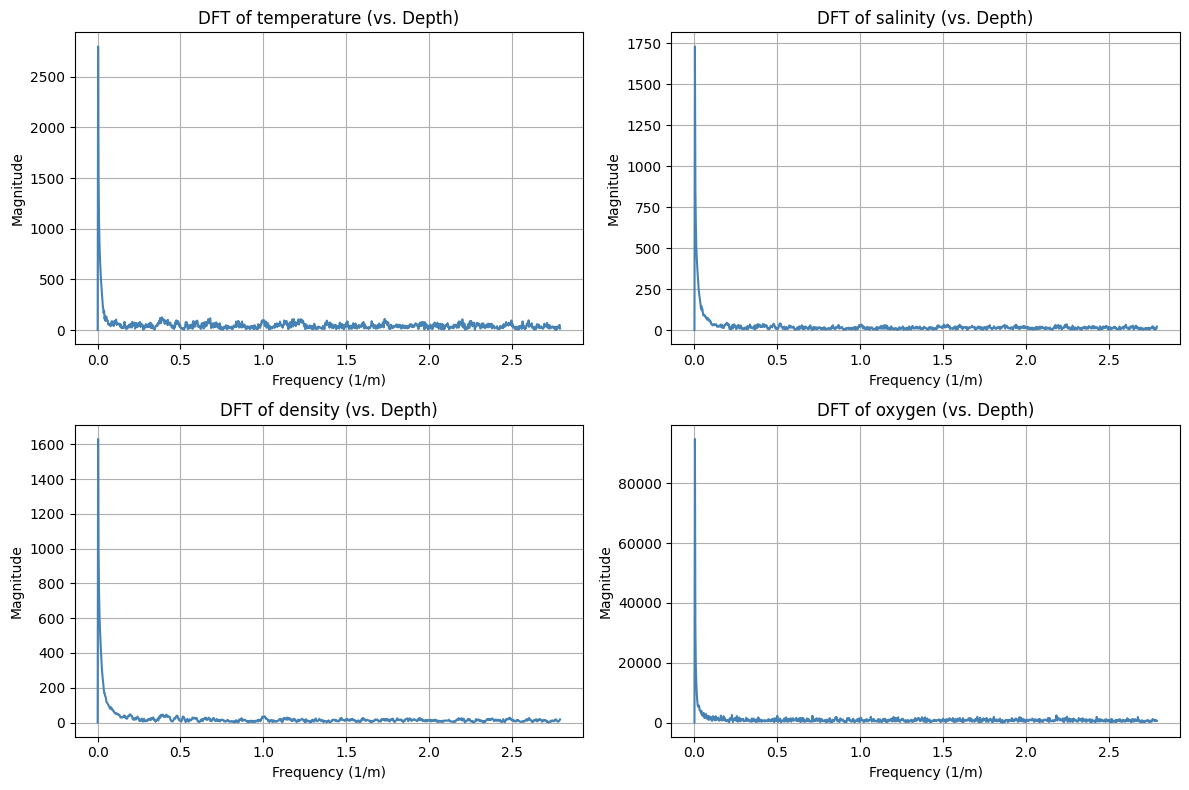

In [ ]:
# -----------------------------------------------------------------------------
# 1) LOAD DATA
# -----------------------------------------------------------------------------
data_dir = os.path.expanduser(data_path)
hdf_file = os.path.join(data_dir, "glider_data.h5")

df = pd.read_hdf(hdf_file, 'data')

# Clean column names
df.columns = df.columns.str.strip()

# Ensure we have the columns we need
required_cols = ["depth", "temperature", "salinity", "density", "oxygen"]
missing = [col for col in required_cols if col not in df.columns]
if missing:
    raise ValueError(f"Missing columns in DataFrame: {missing}")

# -----------------------------------------------------------------------------
# 2) INTERPOLATE ONTO A REGULAR DEPTH GRID
# -----------------------------------------------------------------------------
# Sort by depth
df_sorted = df.dropna(subset=["depth"]).sort_values(by="depth")

# Create a uniform depth array (e.g., from min to max depth, 1000 points)
depth_min = df_sorted["depth"].min()
depth_max = df_sorted["depth"].max()
num_points = 2000  # adjust as needed
depth_grid = np.linspace(depth_min, depth_max, num_points)

# Interpolate each variable onto this depth grid
variables = ["temperature", "salinity", "density", "oxygen"]
interp_data = {}

for var in variables:
    valid_rows = df_sorted.dropna(subset=[var])  # remove rows with NaN in var
    # Depth and var as arrays
    x = valid_rows["depth"].values
    y = valid_rows[var].values

    # Interpolate using numpy's interp (1D)
    interp_data[var] = np.interp(depth_grid, x, y)

# -----------------------------------------------------------------------------
# 3) APPLY DFT
# -----------------------------------------------------------------------------
# We'll treat depth as the "independent variable," so the "sampling interval" is
# the uniform spacing in depth (in meters).
d_depth = depth_grid[1] - depth_grid[0]

plt.figure(figsize=(12, 8))

for i, var in enumerate(variables, 1):
    signal = interp_data[var]
    # Remove mean (DC offset)
    signal_centered = signal - np.mean(signal)

    # Compute the DFT
    freq_domain = np.fft.fft(signal_centered)
    freqs = np.fft.fftfreq(len(signal_centered), d=d_depth)

    # We'll plot only the positive half of the spectrum
    half = len(freqs) // 2
    freqs_pos = freqs[:half]
    spectrum = np.abs(freq_domain[:half])

    # Plot
    plt.subplot(2, 2, i)
    plt.plot(freqs_pos, spectrum, color='steelblue')
    plt.title(f"DFT of {var} (vs. Depth)")
    plt.xlabel("Frequency (1/m)")
    plt.ylabel("Magnitude")
    plt.grid(True)

plt.tight_layout()
plt.show()


# Build a simple linear model

i.e do the simplest thing possible

In [ ]:
# Drop any NaNs in the relevant columns
df_model = df.dropna(subset=["oxygen", "temperature", "salinity", "density"])

# Design matrix (predictors)
X = df_model[["temperature", "salinity", "density"]]  # add more if desired
X = sm.add_constant(X)  # adds an intercept

# Target
y = df_model["oxygen"]

# Fit ordinary least squares
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 oxygen   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                 3.982e+07
Date:                Wed, 12 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:33:18   Log-Likelihood:            -5.5426e+07
No. Observations:            12018966   AIC:                         1.109e+08
Df Residuals:                12018962   BIC:                         1.109e+08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.913e+04     34.300   1723.894      

                            OLS Regression Results                            
Dep. Variable:                 oxygen   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                 3.982e+07
Date:                Wed, 12 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:03:46   Log-Likelihood:            -5.5426e+07
No. Observations:            12018966   AIC:                         1.109e+08
Df Residuals:                12018962   BIC:                         1.109e+08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.913e+04     34.300   1723.894      

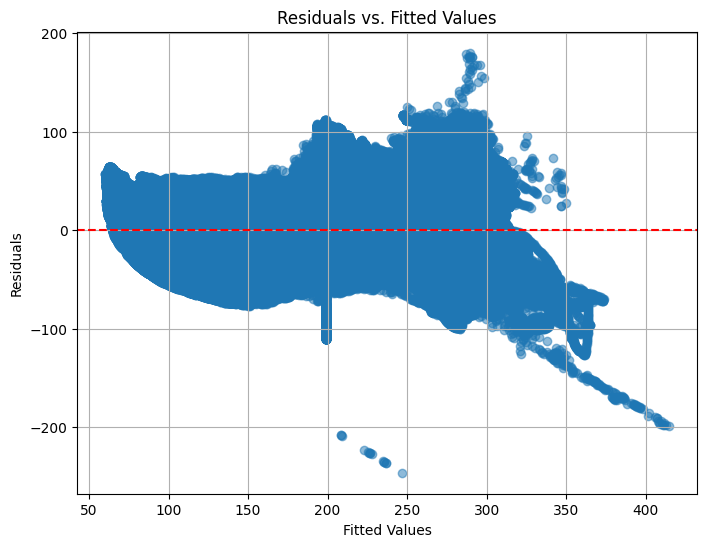

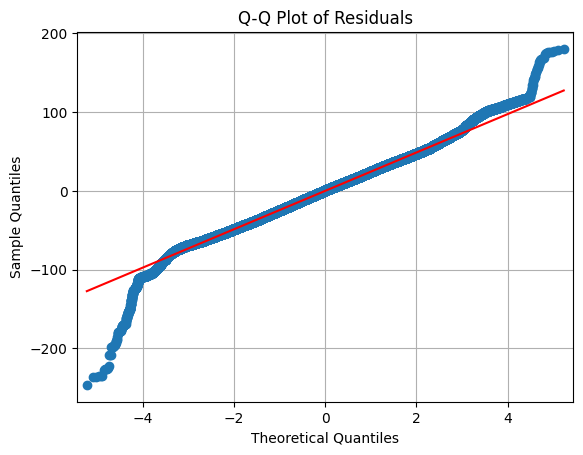

In [ ]:
# Load your data (assuming it's already combined and cleaned in glider_data.h5)
data_dir = os.path.expanduser(data_path)
hdf_file = os.path.join(data_dir, "glider_data.h5")
df = pd.read_hdf(hdf_file, 'data')

# Ensure consistent column names and drop any rows with missing key data.
df.columns = df.columns.str.strip()
df = df.dropna(subset=["oxygen", "temperature", "salinity", "density"])

# Define predictors and target.
X = df[["temperature", "salinity", "density"]]
X = sm.add_constant(X)  # Adds the intercept term.
y = df["oxygen"]

# Fit a simple OLS linear regression model.
model = sm.OLS(y, X).fit()
print(model.summary())

# ---------------------------
# Residuals vs. Fitted Plot
# ---------------------------
plt.figure(figsize=(8, 6))
plt.scatter(model.fittedvalues, model.resid, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.grid(True)
plt.show()

# ---------------------------
# Q-Q Plot of Residuals
# ---------------------------
sm.qqplot(model.resid, line="s")
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()

# Ridge

----- Regression Results -----
Intercept: 210.1029

Coefficients:
temperature: -78.73702239990234
salinity: 137.2887725830078
density: -250.35601806640625
temperature^2: 10.866264343261719
temperature salinity: -138.57781982421875
temperature density: 182.4196014404297
salinity^2: 172.21490478515625
salinity density: -500.4577941894531
density^2: 343.1030578613281

R^2 Score: 0.9313068985939026
Adjusted R^2 Score: 0.9313068471552681


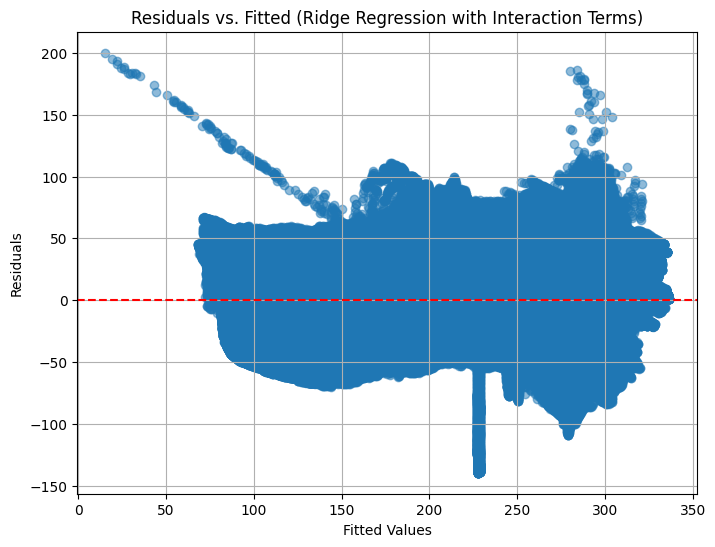

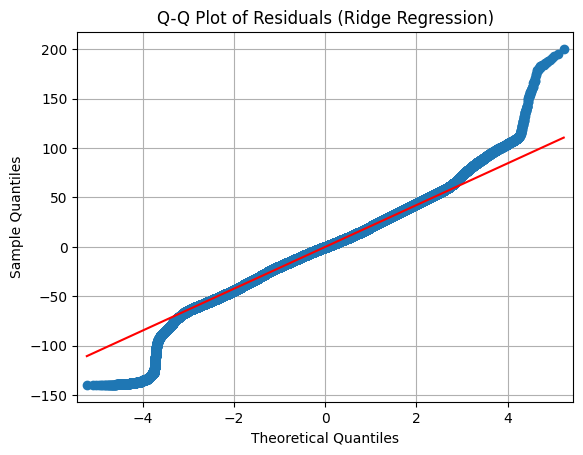

In [7]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# -----------------------------------------------------------------------------
# 1) LOAD & PREPARE DATA
# -----------------------------------------------------------------------------
data_dir = os.path.expanduser(data_path)
hdf_file = os.path.join(data_dir, "glider_data.h5")

df = pd.read_hdf(hdf_file, 'data')
df.columns = df.columns.str.strip()
df = df.dropna(subset=["oxygen", "temperature", "salinity", "density"])

# Define features (X) and target (y)
X = df[["temperature", "salinity", "density"]].values
y = df["oxygen"].values

# -----------------------------------------------------------------------------
# 2) SCALE FEATURES & CREATE POLYNOMIAL (INTERACTION) TERMS
# -----------------------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create polynomial features (degree=2: squares and interactions)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# -----------------------------------------------------------------------------
# 3) FIT RIDGE REGRESSION
# -----------------------------------------------------------------------------
ridge = Ridge(alpha=1.0)  # Adjust alpha as needed
ridge.fit(X_poly, y)
y_pred = ridge.predict(X_poly)
residuals = y - y_pred

# -----------------------------------------------------------------------------
# 4) COMPUTE REGRESSION STATISTICS
# -----------------------------------------------------------------------------
# Standard R^2 score from the model:
r2 = ridge.score(X_poly, y)

# Compute Adjusted R^2:
n = len(y)                # Number of observations
p = X_poly.shape[1]       # Number of predictors (features)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# -----------------------------------------------------------------------------
# 5) PRINT REGRESSION RESULTS
# -----------------------------------------------------------------------------
print("----- Regression Results -----")
print("Intercept:", ridge.intercept_)
print("\nCoefficients:")
# Get feature names from PolynomialFeatures
feature_names = poly.get_feature_names_out(["temperature", "salinity", "density"])
for name, coef in zip(feature_names, ridge.coef_):
    print(f"{name}: {coef}")
print("\nR^2 Score:", r2)
print("Adjusted R^2 Score:", adjusted_r2)

# -----------------------------------------------------------------------------
# 6) PLOT RESIDUALS VS. FITTED VALUES
# -----------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted (Ridge Regression with Interaction Terms)")
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------
# 7) Q-Q PLOT OF RESIDUALS
# -----------------------------------------------------------------------------
sm.qqplot(residuals, line="s")
plt.title("Q-Q Plot of Residuals (Ridge Regression)")
plt.grid(True)
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# -----------------------------------------------------------------------------
# 1) LOAD & PREPARE DATA
# -----------------------------------------------------------------------------
data_dir = os.path.expanduser(data_path)
hdf_file = os.path.join(data_dir, "glider_data.h5")

df = pd.read_hdf(hdf_file, 'data')
df.columns = df.columns.str.strip()

# Example: Use temperature, salinity, density, depth as predictors
df = df.dropna(subset=["oxygen", "temperature", "salinity", "density", "depth"])

X = df[["temperature", "salinity", "density", "depth"]].values
y = df["oxygen"].values

# Optional: If your dataset is huge, you might sample it to reduce training time.
# df = df.sample(n=500000, random_state=42)

# -----------------------------------------------------------------------------
# 2) SPLIT INTO TRAIN & TEST
# -----------------------------------------------------------------------------
# We split the data to assess generalization. Adjust test_size as needed.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------------------------------------------------
# 3) TRAIN RANDOM FOREST
# -----------------------------------------------------------------------------
# Adjust n_estimators, max_depth, etc., based on your dataset size & complexity.
rf = RandomForestRegressor(
    n_estimators=50,   # number of trees
    max_depth=None,    # let trees grow fully; can tune to prevent overfitting
    random_state=42,
    n_jobs=-1          # use all CPU cores for speed
)
rf.fit(X_train, y_train)

# -----------------------------------------------------------------------------
# 4) PREDICT & EVALUATE
# -----------------------------------------------------------------------------
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
residuals = y_test - y_pred

print(f"Random Forest R² on test set: {r2:.4f}")

# -----------------------------------------------------------------------------
# 5) RESIDUALS vs. FITTED PLOT
# -----------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values (Predicted Oxygen)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Fitted (Random Forest)")
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------
# 6) Q-Q PLOT OF RESIDUALS
# -----------------------------------------------------------------------------
sm.qqplot(residuals, line="s")
plt.title("Q-Q Plot of Residuals (Random Forest)")
plt.grid(True)
plt.show()